<a href="https://colab.research.google.com/github/Paimonz/computer-vision/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
                                                           #Saiba mais em:

import matplotlib.pyplot as plt                            #https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
import numpy as np                                         #https://numpy.org/doc/
import tensorflow as tf                                    #https://www.tensorflow.org/api_docs/python/tf
import tensorflow_hub as hub                               #https://www.tensorflow.org/hub?hl=pt-br
from keras.preprocessing.image import ImageDataGenerator   #https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

print('TensorFlow version:', tf.__version__)               #Verifica a versão do TensorFlow.
print('TensorFlow Hub version:', hub.__version__)          #Verifica a versão do TensorFlow Hub.

TensorFlow version: 2.13.0
TensorFlow Hub version: 0.14.0


In [3]:
#O TensorFlow Hub tem vários modelos de classificação, você pode verificar outros modelos em:
#https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2&q=efficientnet
#Usei o modelo efficientnetv2-b2-21k pois acredito ser mais adequato para os tipos de imagens que tenho.

model_name = 'efficientnetv2-b2-21k'

In [4]:
#Criando uma nova variavel, armazenado o caminho do modelo.
#O primeiro parametro é o nome do modelo e o segundo é o link para donwload do modelo.

models_path = {
    "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
}

In [5]:
#Criando nova variavel para a dimensões das imagens, pois cada modelo trabalha com uma dimensão expecifica.
#Para trabalhar com o modelo escolhido as imagens tem que ser igual ou inferior as dimensões 260x260.

models_pixels = {
    "efficientnetv2-b2-21k": 260
}

In [6]:
#Armezenando o caminho do modelo através do nome do nomdelo.

model_path = models_path.get(model_name)
model_path

'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2'

In [7]:
#Armazenando as dimensões/pixels do modelo atravéz do nome do modelo.

pixels = models_pixels.get(model_name)
pixels

260

In [8]:
#Criando o formato das imagens.

image_size = (pixels, pixels)
image_size

(260, 260)

In [9]:
print('Model: ', model_name)          #Para mostrar com qual modelo estamos trabalhando.
print('Path: ', model_path)           #Mostrando o caminho/link onde é possível encontrar o modelo.
print('Imagem size: ', image_size)    #Revelando o formato das imagens que serão trabalhadas no projeto.

Model:  efficientnetv2-b2-21k
Path:  https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2
Imagem size:  (260, 260)


In [10]:
#O dataset foi criado/configurado e armazenado no google driver, para seguir esse modelo vc precisará criar o seu próprio dataset e montar o seu driver.
#Saiba mais em: https://saturncloud.io/blog/how-to-import-files-from-google-drive-to-colab/
#Você pode encontrar as imagens utilizadas nesse projeto em: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

flow_from_directory = "/content/drive/MyDrive/dataset1" #método da classe ImageDataGenerator que permite ler imagens de um grande array numpy e pastas contendo imagens.
data_directory = flow_from_directory                                   #Armazena o caminho do flow_from_directory em data_directory.
print(data_directory)                                                  #Mostra o caminho do data_directory.

/content/drive/MyDrive/dataset1


In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory,            #Pegando as imagens que estão no data_directory para o treino
                                                                    validation_split= .20,     #Usaremos 20% do dataset para validação.
                                                                    subset = 'training',       #Significa que essa parte do conjunto de dados é o treinamento.
                                                                    label_mode='categorical',  #Etiqueta do nosso modelo será por categoria, Catarata ou Normal.
                                                                    seed = 123,                #Toda vez que a função for chamada será composta pelas mesmas imagens.
                                                                    image_size=image_size,     #Configura o formato das imagens.
                                                                    batch_size=1)              #Número de amostras processadas antes do modelo ser atualizado.

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [12]:
#Mostra o nome das classes que temos no nosso treinamento

train_dataset.class_names

['0_normal', '1_cataract', '2_glaucoma', '3_diabetic_retinopathy']

In [13]:
#Criando uma variavel com os nomes das classes do nosso dataset

classes = train_dataset.class_names
classes

['0_normal', '1_cataract', '2_glaucoma', '3_diabetic_retinopathy']

In [14]:
 #A função da cardinality retorna o número de elementos em uma lista, no caso irá retorno o número de arquivos usados no treinameno (train_dataset).

training_size = train_dataset.cardinality().numpy()
training_size

3374

In [15]:
#Organizando o dataset em 52 lotes, onde cada lote terá (840/16 = 52,5) 16 imagens.

BATCH_SIZE = 16 #Significa que existem 16 instâncias de treinamento em cada lote.


In [16]:
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE) #Atualizando o batch_size porque inicialmente começamos com batch_size =1
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [17]:
840/16


52.5

In [18]:
# https://www.tensorflow.org/api_docs/python/tf/repeat
# https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset

train_dataset = train_dataset.repeat()

In [19]:
#Image augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation
#from multiprocessing.process import parent_process

normalization_layer = tf.keras.layers.Rescaling(1. /255)            #Normalization = transformação de dados que alinha os valores dos dados a uma escala comum. Rescaling = reduzindo a escala (pixels) das imagens de 0-255 para 0-1.
pre_processing = tf.keras.Sequential([normalization_layer])         #Sequential = irá criar a estrutura da rede neural, que será passado uma sequencia de camadas por isso usaremos sequential.
pre_processing.add(tf.keras.layers.RandomRotation(40))              #Irá girar algumas imagens aleatório em 40° e adicionar no pré-processamento, pois pode ser que as imagens separadas para o treinamento não sejam o suficienteentão será necessário "criar" mais imagens para o mesmo.
pre_processing.add(tf.keras.layers.RandomTranslation(0, 0.2))       #O segundo parametro é a largura, irá deslocar as imagens aleatóriamente em 20% na horizontal.
pre_processing.add(tf.keras.layers.RandomTranslation(0.2, 0))       #O primeiro parametro é a altura, irá deslocar as imagens aleatóriamente em 20% na vertical.
pre_processing.add(tf.keras.layers.RandomZoom(0.2, 0.2))            #Adicionando imagens aleatórias com o zoom aumentando em 20% e com o zoom reduzido em 20%.
pre_processing.add(tf.keras.layers.RandomFlip(mode = 'horizontal')) #Gira as imagens horizontalmente.

In [20]:
#MAP em Python é uma função que funciona como um iterador para retornar um resultado após aplicar uma função a cada item de um iterável (tupla, listas, etc.). É usado quando
#você deseja aplicar uma única função de transformação a todos os elementos iteráveis. O iterável e a função são passados como argumentos para o mapa em Python.

#As funções LAMBDA são semelhantes às funções definidas pelo usuário, mas sem nome. Eles são comumente chamados de funções anônimas. As funções lambda são eficientes sempre que
#você deseja criar uma função que contenha apenas expressões simples – ou seja, expressões que geralmente são uma única linha de uma instrução.

train_dataset = train_dataset.map(lambda images, labels: (pre_processing(images), labels))    #Irá mandar as imagens para o pre_processing.
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [21]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_directory,
                                                                   validation_split= .20,
                                                                   subset ='validation',          #Agora o nome do subconjunto será validation, que usaremos para o teste.
                                                                   label_mode ='categorical',
                                                                   seed = 123,
                                                                   image_size = image_size,
                                                                   batch_size = 1)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [22]:
test_size = test_dataset.cardinality().numpy()    #Extrai a quantidade de imagens que será utilizada para o teste
test_size                                         #Mostra a quantidade de imagens que iremos utilizar para o teste

843

In [23]:
#Será necessário alterar o conjunto de dados para o mesmo formado utilizado no treinamento.

test_dataset = test_dataset.unbatch().batch(BATCH_SIZE)
test_dataset = test_dataset.map(lambda images, labels: (pre_processing(images), labels))

In [24]:
model = tf.keras.Sequential([                                                              #Uma rede neural é composta por uma sequencia de camadas.
                              tf.keras.layers.InputLayer(input_shape= image_size + (3,)),  #Entrada da imagens, o número 3 é devido a imagen ser colorida RGB
                              hub.KerasLayer(model_path, trainable = False),               #Fazer o download do modelo, "trainable = False" isso significa que quando treinarmos a rede neural, não vamos treinar esses pesos que já estão armazenado no modelo do qual faremos o download.
                              tf.keras.layers.Dropout(rate = 0.2),                         #Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
                              tf.keras.layers.Dense(len(classes))                          #O quantidade de neurônios de sáida deverá ser a mesma quntidade de de classes
])

In [25]:
(None, ) + image_size + (3, )

(None, 260, 260, 3)

In [26]:
model.build((None, )+ image_size + (3,))  #O primeiro parametro siginifica a quantidade de imagens que será enviada para o modelo, por isso começa "vazia".
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1408)              8769374   
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 4)                 5636      
                                                                 
Total params: 8775010 (33.47 MB)
Trainable params: 5636 (22.02 KB)
Non-trainable params: 8769374 (33.45 MB)
_________________________________________________________________


In [27]:
#Adam = O algoritmo Adaptive Movement Estimation, ou Adam, para abreviar, é uma extensão da descida gradiente e um sucessor natural de técnicas como AdaGrad e RMSProp que adapta
#automaticamente uma taxa de aprendizagem para cada variável de entrada para a função objetivo e suaviza ainda mais o processo de pesquisa usando um exponencialmente.

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = 'accuracy')

In [28]:
steps_per_epoch = training_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE
print(steps_per_epoch, validation_steps)

210 52


In [29]:
#"model.fir" a rede neural começará a treinar, os pesos serão ajustados e vamos enviar o treino.
#Epochs = Uma época é quando todos os dados de treinamento são usados ​​de uma vez e é definida como o número total de iterações de todos os dados de treinamento em um ciclo para treinar o modelo de aprendizado de máquina

hist = model.fit(train_dataset, epochs= 5, steps_per_epoch = steps_per_epoch,
                 validation_data = test_dataset, validation_steps = validation_steps).history

Epoch 1/5
210/210 [==============================] - 679s 3s/step - loss: 0.8951 - accuracy: 0.6542 - val_loss: 0.5896 - val_accuracy: 0.7800
Epoch 2/5
210/210 [==============================] - 649s 3s/step - loss: 0.6767 - accuracy: 0.7391 - val_loss: 0.5057 - val_accuracy: 0.7981
Epoch 3/5
210/210 [==============================] - 666s 3s/step - loss: 0.6395 - accuracy: 0.7516 - val_loss: 0.5191 - val_accuracy: 0.7873
Epoch 4/5
210/210 [==============================] - 642s 3s/step - loss: 0.5727 - accuracy: 0.7778 - val_loss: 0.4665 - val_accuracy: 0.8197
Epoch 5/5
210/210 [==============================] - 655s 3s/step - loss: 0.5599 - accuracy: 0.7877 - val_loss: 0.4780 - val_accuracy: 0.8185


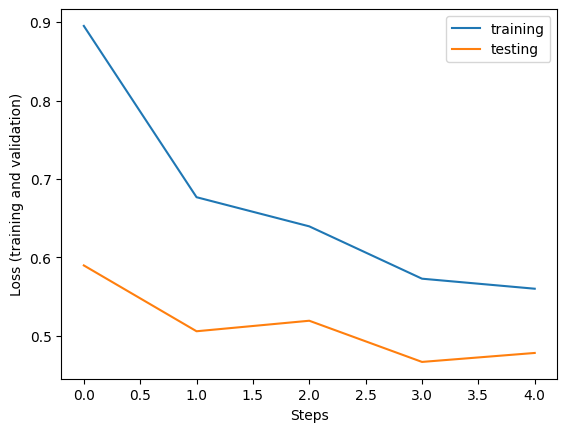

In [30]:
plt.figure()                                                #O gráfico é interessante pois assim você consegue saber por quantas épocas será necessário treinar o modelo.
plt.ylabel('Loss (training and validation)')
plt.xlabel('Steps')
plt.plot(hist['loss'], label = 'training')
plt.plot(hist['val_loss'], label = 'testing')
plt.legend();

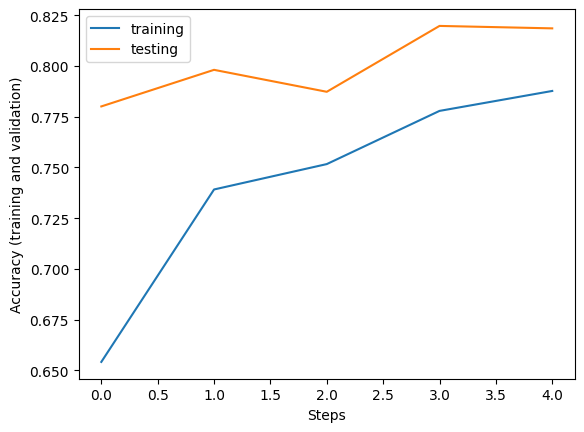

In [31]:
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Steps')
plt.plot(hist['accuracy'], label = 'training')
plt.plot(hist['val_accuracy'], label = 'testing')
plt.legend();

In [32]:
#Criando duas variáveis, x e y: x = será o pixels da imagens e y = será o rotulo/etiqueta.
#Precisamos usar a função "Next" para obter a próxima imagem.
#iter é um parâmetro da função, é o iterador sobre o qual a iteração deve ser realizada.
#O segundo paramêtro da função "test_dataset" será o valor padrão a ser impresso se chegarmos ao final do iterador.

x, y = next(iter(test_dataset))


In [33]:
#As informações abaixo são referente aos pixels das imagens

x

<tf.Tensor: shape=(16, 260, 260, 3), dtype=float32, numpy=
array([[[[3.78098488e-01, 3.34341258e-01, 3.14481646e-01],
         [3.74070495e-01, 3.32051605e-01, 3.14279944e-01],
         [3.75118107e-01, 3.34657878e-01, 3.17240953e-01],
         ...,
         [5.07808149e-01, 3.62564385e-01, 3.22285235e-01],
         [5.03076553e-01, 3.64658296e-01, 3.24408323e-01],
         [4.84309465e-01, 3.67065102e-01, 3.32037747e-01]],

        [[3.83356661e-01, 3.36771816e-01, 3.17835093e-01],
         [3.80688041e-01, 3.36162984e-01, 3.19187284e-01],
         [3.83240283e-01, 3.39300424e-01, 3.22824210e-01],
         ...,
         [5.43865204e-01, 3.76161605e-01, 3.34563702e-01],
         [5.36595404e-01, 3.76224935e-01, 3.36949050e-01],
         [5.16405106e-01, 3.74012202e-01, 3.38614166e-01]],

        [[3.94453049e-01, 3.42159271e-01, 3.19525778e-01],
         [3.90972376e-01, 3.41590255e-01, 3.20599377e-01],
         [3.91197771e-01, 3.42983872e-01, 3.22621852e-01],
         ...,
         [

In [34]:
#Em cada lote tem 16 imagens, de 260x260 pixels coloridas(RGB).

x.shape

TensorShape([16, 260, 260, 3])

In [35]:
#as linhas são referente as imagens no lote e as colunas são referente as classes.

y

<tf.Tensor: shape=(16, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [36]:
#Em cada lote tem 16 imagens com duas classes possíevis.

y.shape

TensorShape([16, 4])

In [37]:
#Para classificar a imagem, o 1° parametro é a possição da imagem, 2° e 3° são os pixels e o 4° é referente ao canal de cores.

image = x[0, :, :, :]
image

<tf.Tensor: shape=(260, 260, 3), dtype=float32, numpy=
array([[[0.3780985 , 0.33434126, 0.31448165],
        [0.3740705 , 0.3320516 , 0.31427994],
        [0.3751181 , 0.33465788, 0.31724095],
        ...,
        [0.50780815, 0.36256438, 0.32228523],
        [0.50307655, 0.3646583 , 0.32440832],
        [0.48430946, 0.3670651 , 0.33203775]],

       [[0.38335666, 0.33677182, 0.3178351 ],
        [0.38068804, 0.33616298, 0.31918728],
        [0.38324028, 0.33930042, 0.3228242 ],
        ...,
        [0.5438652 , 0.3761616 , 0.3345637 ],
        [0.5365954 , 0.37622494, 0.33694905],
        [0.5164051 , 0.3740122 , 0.33861417]],

       [[0.39445305, 0.34215927, 0.31952578],
        [0.39097238, 0.34159026, 0.32059938],
        [0.39119777, 0.34298387, 0.32262185],
        ...,
        [0.58361095, 0.39415687, 0.35089386],
        [0.57298696, 0.39373124, 0.34886405],
        [0.5552897 , 0.39012614, 0.34282678]],

       ...,

       [[0.53247684, 0.3881862 , 0.35241508],
        [0.51

In [38]:
y_true = y[0]  #Selecionando a imagem que está na posição 3
y_true

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>

In [39]:
y_true = np.argmax(y[0]) #np.argmax irá retonar a posição do maior valor no conjunto de array.
y_true

3

In [40]:
classes[3] #a classe referente a posição 1 é a Catarata.

'3_diabetic_retinopathy'

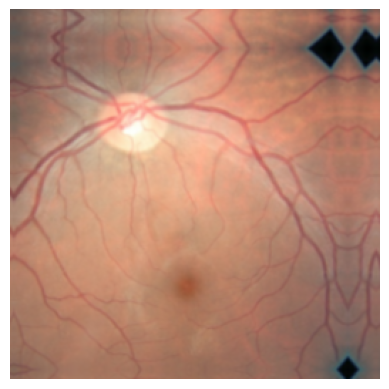

In [41]:
plt.imshow(image)
plt.axis('off');

In [42]:
image.shape #Formato da imagem 1° e 2° = dimensão da imagem e 3° canal de cores.

TensorShape([260, 260, 3])

In [43]:
image = np.expand_dims(image, axis = 0) #Para enviar para a rede neural, precisamos converter esse formato para o formato em lote.
image.shape

(1, 260, 260, 3)

In [44]:
prediction = model.predict(image)
prediction

1/1 [==============================] - 1s 1s/step


array([[-0.2681191, -9.446066 , -3.6260016,  5.7117705]], dtype=float32)

In [45]:
prediction = np.argmax(prediction) #Fazendo a classificação da imagem
prediction

3

In [46]:
classes[3]

'3_diabetic_retinopathy'